# EX16 CGAN pix2pix  
## Objective : Segmentation map으로 도로 이미지 만들기   
1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.  
- 데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.  
2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.  
- U-Net generator, discriminator 모델 구현이 완료되어 train_step의 output을 확인하고 개선하였다.  
3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.  
- 10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.  

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import os


### 데이터 불러오기 및 확인

In [2]:
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


일단 데이터셋을 확인해보겠습니다

(256, 512, 3)
(256, 512, 3)
(256, 512, 3)
(256, 512, 3)
(256, 512, 3)
(256, 512, 3)


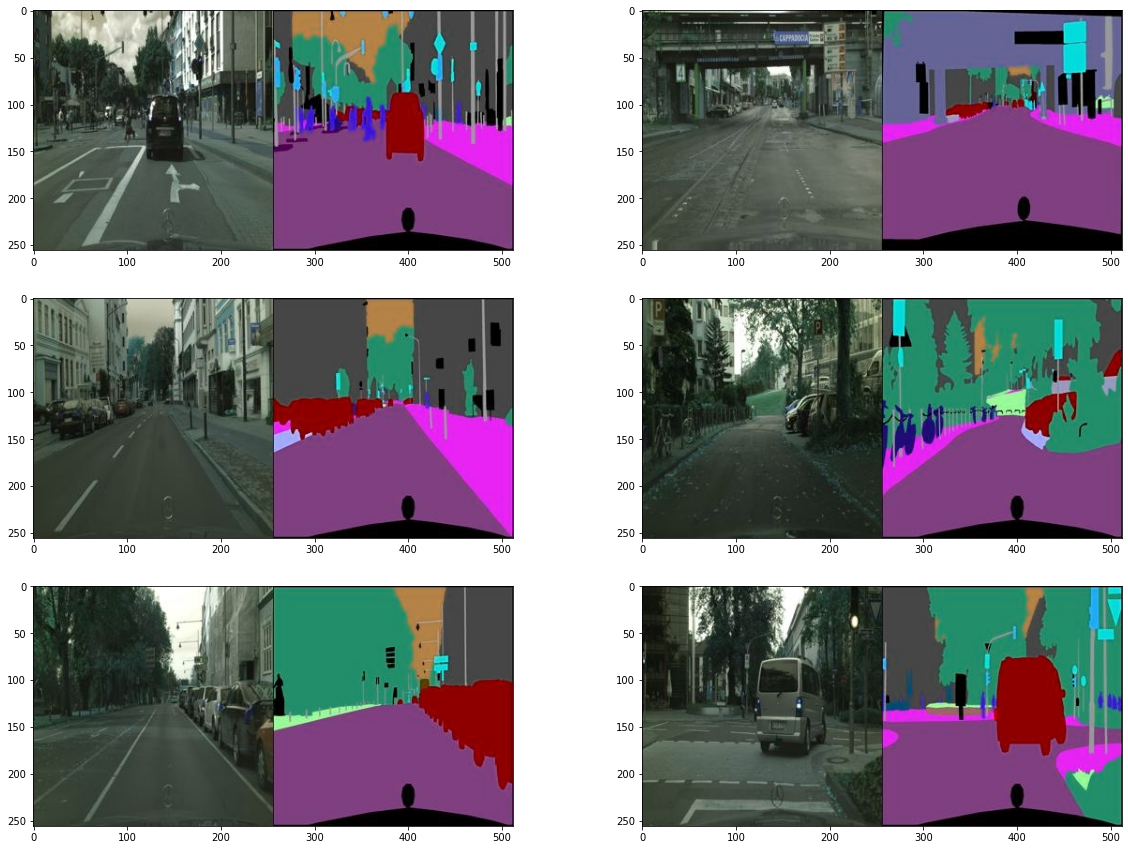

In [3]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)
    print(img.shape)

실제 사진과 스케치가 한장에 포함되어 있습니다  
이미지 정보 : h 256 w 512 c 3  

이미지를 세로축 절반으로 잘라 따로 저장하도록 하겠습니다

In [4]:
# -1 ~ 1로 정규화  

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

In [5]:
# 이미지를 읽어와, 정규화하는 함수
# 실제 이미지는 pic, 색칠된 이미지는 marked로 칭하도록 하겠습니다

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    pic = img[:, :w, :] 
    pic = tf.cast(pic, tf.float32)
    marked = img[:, w:, :] 
    marked = tf.cast(marked, tf.float32)
    return normalize(pic), normalize(marked)

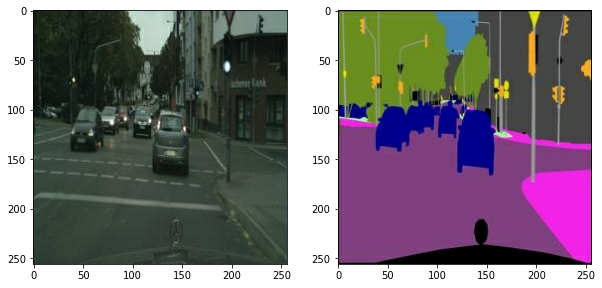

In [6]:
f = data_path + os.listdir(data_path)[1]
picture, marked = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(picture))
plt.subplot(1,2,2); plt.imshow(denormalize(marked))

#### Data augmentation 사용하기

In [7]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

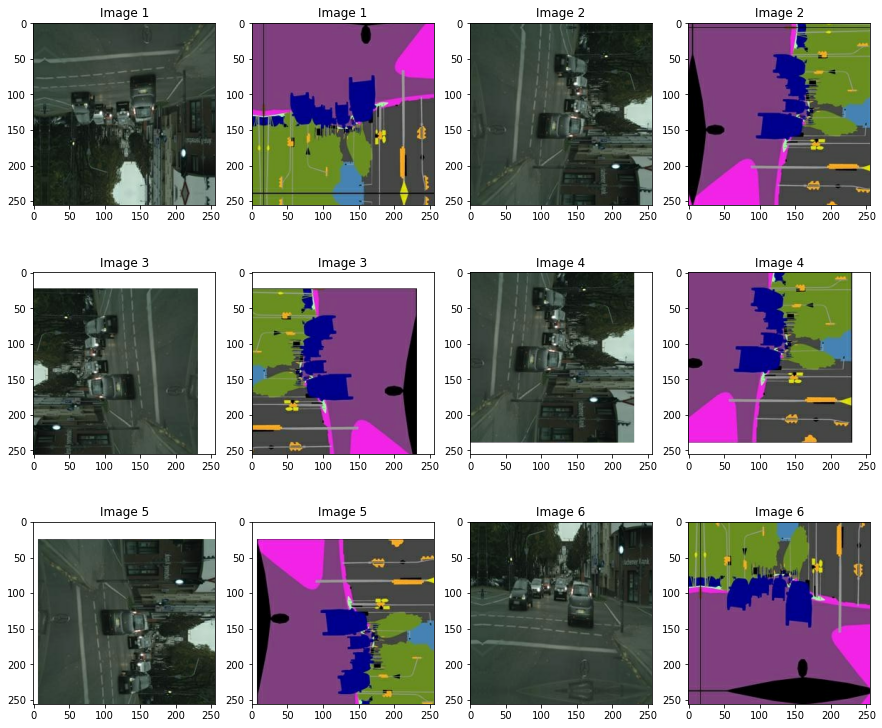

In [8]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_picture, augmented_marked = apply_augmentation(picture, marked)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_picture)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_marked)); plt.title(f"Image {img_n}")
    img_n += 1

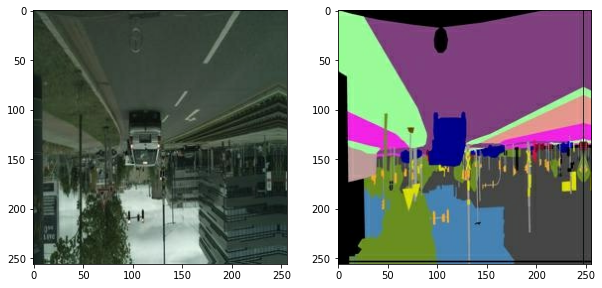

In [9]:
from tensorflow import data

def get_train(img_path):
    picture, marked = load_img(img_path)
    picture, marked = apply_augmentation(picture, marked)
    return picture, marked

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
picture, marked = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(picture[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(marked[0].astype(np.uint8))

### CGAN GENERATOR 구성하기

In [10]:
from tensorflow.keras import layers, Input, Model

In [11]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)


In [12]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [13]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [14]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

### CGAN DISCRIMINATOR 구성하기

In [15]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 


In [16]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    

In [17]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

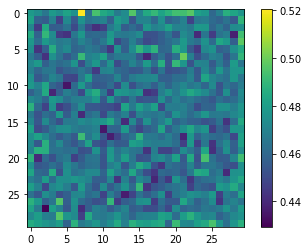

In [18]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

#### 손실함수 설계

In [19]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)


In [20]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)


학습

In [21]:
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [22]:
EPOCHS = 1

generator = UNetGenerator()
discriminator = Discriminator()

In [23]:
g_loss_trace = []
l1_loss_trace = []
d_loss_trace = []

In [24]:
for epoch in range(1, EPOCHS+1):
    for i, (picture, marked) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(picture, marked)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")
    
        g_loss_trace.append(g_loss)
        l1_loss_trace.append(l1_loss)
        d_loss_trace.append(d_loss)

EPOCH[1] - STEP[10]                     
Generator_loss:0.9515                     
L1_loss:0.3682                     
Discriminator_loss:1.2837

EPOCH[1] - STEP[20]                     
Generator_loss:0.9006                     
L1_loss:0.3103                     
Discriminator_loss:1.1131

EPOCH[1] - STEP[30]                     
Generator_loss:1.1442                     
L1_loss:0.3231                     
Discriminator_loss:0.9108

EPOCH[1] - STEP[40]                     
Generator_loss:1.2070                     
L1_loss:0.2740                     
Discriminator_loss:0.8431

EPOCH[1] - STEP[50]                     
Generator_loss:1.8759                     
L1_loss:0.2666                     
Discriminator_loss:0.5580

EPOCH[1] - STEP[60]                     
Generator_loss:1.7508                     
L1_loss:0.2745                     
Discriminator_loss:0.5555

EPOCH[1] - STEP[70]                     
Generator_loss:1.7788                     
L1_loss:0.2923                    

In [34]:
test_ind = [1,2,3]
test_pic_group = []

total_cnt = 0
t_picture = []
t_marked = []
t_pred = []

test_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/val/'

for i in range(len(test_ind)):

    f = test_path + os.listdir(test_path)[test_ind[i]]
    test_picture, test_marked = load_img(f)
    t_picture.append(test_picture)
    t_marked.append(test_marked)

res_pred = []

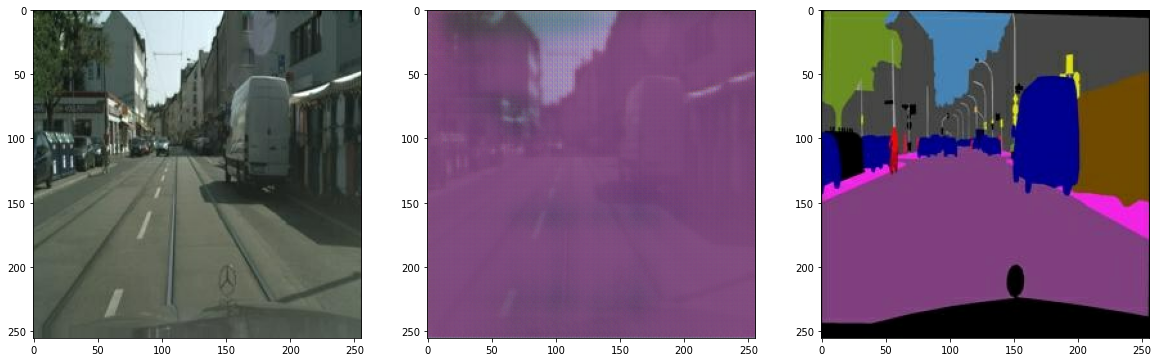

In [28]:
for i in range(len(test_ind)):

    pred = generator(tf.expand_dims(t_picture[i], 0))
    pred = denormalize(pred)
    
    pred_pics = []
    pred_pics.append(pred[0])
    res_pred.append(pred_pics)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(t_picture[0]))
plt.subplot(1,3,2); plt.imshow(res_pred[0][0])
plt.subplot(1,3,3); plt.imshow(denormalize(t_marked[0]))



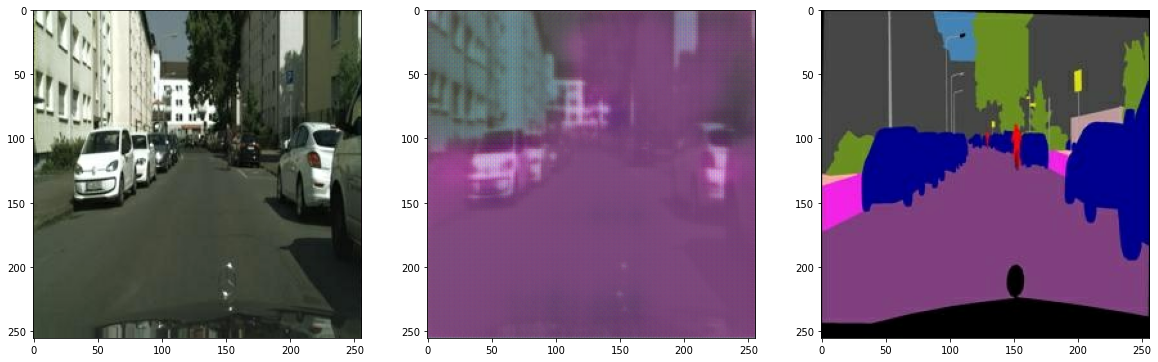

In [29]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(t_picture[1]))
plt.subplot(1,3,2); plt.imshow(res_pred[1][0])
plt.subplot(1,3,3); plt.imshow(denormalize(t_marked[1]))

에폭 1회 결과입니다  
무언가 원본 이미지의 디테일이 그대로 남아있고, 전체적인 색감만이 반영되어 있습니다

In [30]:
EPOCHS = 9
total_cnt = 1

In [31]:
for epoch in range(1, EPOCHS+1):
    for i, (picture, marked) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(picture, marked)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")
    
        g_loss_trace.append(g_loss)
        l1_loss_trace.append(l1_loss)
        d_loss_trace.append(d_loss)

    for j in range(len(test_ind)):

        pred = generator(tf.expand_dims(t_picture[j], 0))
        pred = denormalize(pred)

        res_pred[j].append(pred[0])
        
    total_cnt += 1

EPOCH[1] - STEP[10]                     
Generator_loss:2.1702                     
L1_loss:0.2144                     
Discriminator_loss:0.5753

EPOCH[1] - STEP[20]                     
Generator_loss:1.5738                     
L1_loss:0.1919                     
Discriminator_loss:0.9231

EPOCH[1] - STEP[30]                     
Generator_loss:1.8396                     
L1_loss:0.2449                     
Discriminator_loss:0.4910

EPOCH[1] - STEP[40]                     
Generator_loss:2.7608                     
L1_loss:0.2116                     
Discriminator_loss:0.8639

EPOCH[1] - STEP[50]                     
Generator_loss:0.8138                     
L1_loss:0.2366                     
Discriminator_loss:1.1148

EPOCH[1] - STEP[60]                     
Generator_loss:1.4499                     
L1_loss:0.2522                     
Discriminator_loss:0.6796

EPOCH[1] - STEP[70]                     
Generator_loss:2.8996                     
L1_loss:0.2560                    

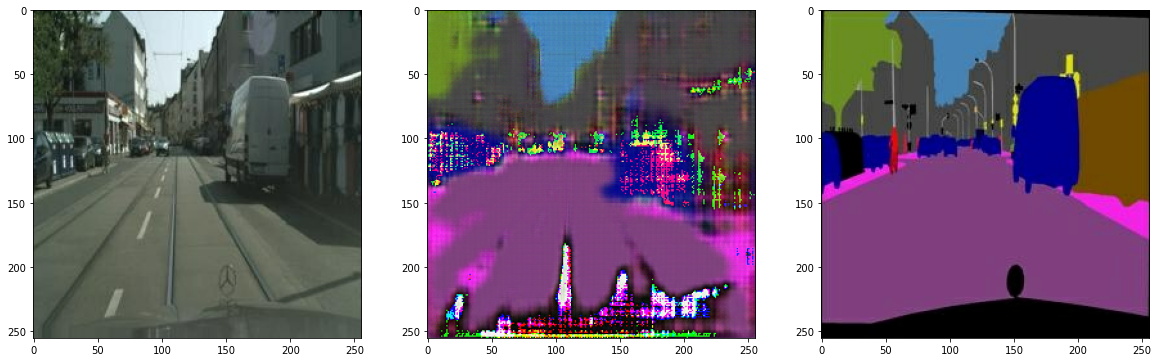

In [35]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(t_picture[0]))
plt.subplot(1,3,2); plt.imshow(res_pred[0][total_cnt-1])
plt.subplot(1,3,3); plt.imshow(denormalize(t_marked[0]))

에폭 10회 결과입니다  
Prediction 결과가 점차 디테일을 갖춰감을 확인할 수 있었습니다

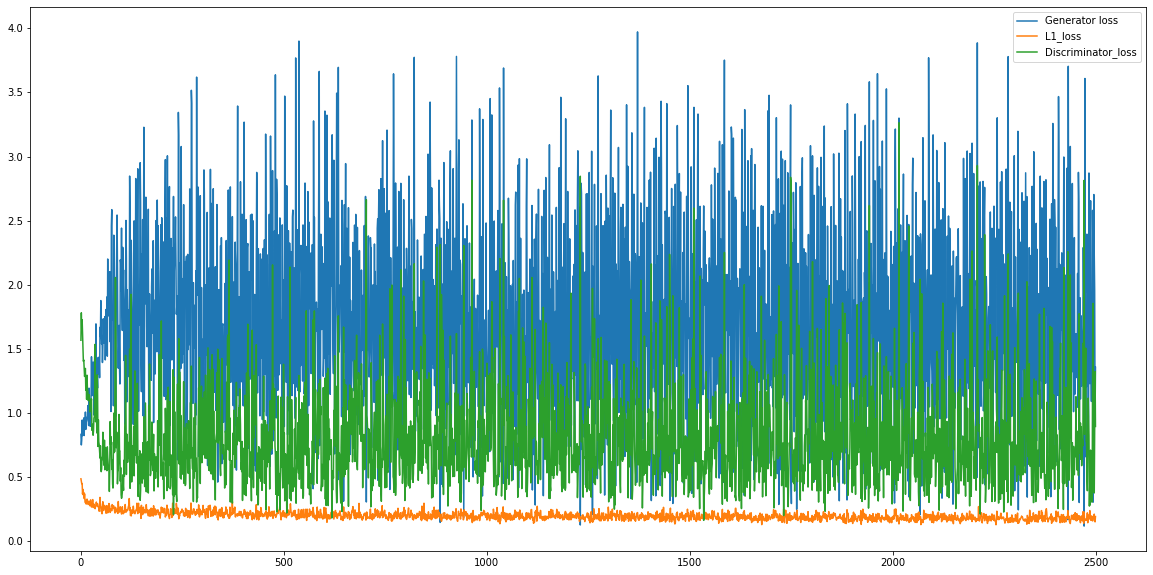

In [38]:
plt.figure(figsize=(20,10))
plt.plot(g_loss_trace, label='Generator loss')
plt.plot(l1_loss_trace, label='L1_loss')
plt.plot(d_loss_trace, label='Discriminator_loss')
plt.legend()

In [39]:
EPOCHS = 50

In [ ]:
for epoch in range(1, EPOCHS+1):
    for i, (picture, marked) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(picture, marked)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")
    
        g_loss_trace.append(g_loss)
        l1_loss_trace.append(l1_loss)
        d_loss_trace.append(d_loss)
        
    for j in range(len(test_ind)):

        pred = generator(tf.expand_dims(t_picture[j], 0))
        pred = denormalize(pred)

        res_pred[j].append(pred[0])
        
    total_cnt += 1

EPOCH[1] - STEP[10]                     
Generator_loss:0.6991                     
L1_loss:0.1905                     
Discriminator_loss:0.9371

EPOCH[1] - STEP[20]                     
Generator_loss:2.7450                     
L1_loss:0.1870                     
Discriminator_loss:0.8808

EPOCH[1] - STEP[30]                     
Generator_loss:3.1656                     
L1_loss:0.1672                     
Discriminator_loss:0.9926

EPOCH[1] - STEP[40]                     
Generator_loss:0.8935                     
L1_loss:0.1640                     
Discriminator_loss:1.0022

EPOCH[1] - STEP[50]                     
Generator_loss:1.7354                     
L1_loss:0.1947                     
Discriminator_loss:0.3367

EPOCH[1] - STEP[60]                     
Generator_loss:1.1022                     
L1_loss:0.1881                     
Discriminator_loss:0.5108

EPOCH[1] - STEP[70]                     
Generator_loss:0.5479                     
L1_loss:0.1793                    

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(t_picture[0]))
plt.subplot(1,3,2); plt.imshow(res_pred[0][total_cnt-1])
plt.subplot(1,3,3); plt.imshow(denormalize(t_marked[0]))

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(g_loss_trace, label='Generator loss')
plt.plot(l1_loss_trace, label='L1_loss')
plt.plot(d_loss_trace, label='Discriminator_loss')
plt.legend()